# Assignment 2
# Ling Fei Zhang, 260985358
# Brandon Ma, 260983550

## Question 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions import SARSA
import time
import gymnasium as gym
import random
from tqdm import tqdm

c:\Users\Ling0\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here, we will set a few parameters for our environment.

In [2]:
ALPHAS = [0.1, 0.3, 0.6]
GAMMA = 0.95
TEMPERATURE = [0.5, 50, 100]
EPISODES = 5500
SEEDS = np.arange(10)
EPSILON = 0.2

Driver Code to test out the combination of each alpha with each temperature for SARSA.

In [3]:
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=False)
env.reset()
sarsa = SARSA(env, 0.1, 0.5, GAMMA, EPISODES, False, EPSILON)
sarsa.simulate_episodes()
final_policy = sarsa.learned_policy
print("final policy:\n", final_policy.reshape(4,4)) #tabular format to better visualize
train_reward = sarsa.train_reward()
print(f"train reward: {train_reward}")
test_reward = sarsa.test_reward()
print(f"test reward: {test_reward}")
reward = sarsa.reward
print("total reward: \n", reward)


#uncomment this line if you want to vizualize the game
# sarsa.visualize(10)

  4%|▍         | 247/5500 [00:00<00:02, 2450.12it/s]

episode 100, preferences [0.25 0.25 0.25 0.25]
episode 100, preferences [0.25 0.25 0.25 0.25]
episode 100, preferences [0.25 0.25 0.25 0.25]
episode 100, preferences [0.25 0.25 0.25 0.25]
episode 100, preferences [0.25 0.25 0.25 0.25]
episode 100, preferences [0.25 0.25 0.25 0.25]
episode 101, preferences [0.25 0.25 0.25 0.25]
episode 101, preferences [0.25 0.25 0.25 0.25]
episode 101, preferences [0.25 0.25 0.25 0.25]
episode 101, preferences [0.25 0.25 0.25 0.25]
episode 102, preferences [0.25 0.25 0.25 0.25]
episode 102, preferences [0.25 0.25 0.25 0.25]
episode 102, preferences [0.25 0.25 0.25 0.25]
episode 102, preferences [0.25 0.25 0.25 0.25]
episode 102, preferences [0.25 0.25 0.25 0.25]
episode 102, preferences [0.25 0.25 0.25 0.25]
episode 102, preferences [0.25 0.25 0.25 0.25]
episode 102, preferences [0.25 0.25 0.25 0.25]
episode 103, preferences [0.25 0.25 0.25 0.25]
episode 103, preferences [0.25 0.25 0.25 0.25]
episode 103, preferences [0.25 0.25 0.25 0.25]
episode 103, 

 12%|█▏        | 686/5500 [00:00<00:02, 1759.39it/s]

episode 464, preferences [0.24987919 0.25049804 0.24977323 0.24984954]
episode 464, preferences [0.24987919 0.25049804 0.24977323 0.24984954]
episode 464, preferences [0.24987879 0.25049817 0.24977336 0.24984967]
episode 464, preferences [0.24996163 0.25008378 0.25000157 0.24995301]
episode 464, preferences [0.24996163 0.25008378 0.25000157 0.24995301]
episode 464, preferences [0.24996693 0.24990387 0.25013541 0.2499938 ]
episode 464, preferences [0.24996636 0.25008527 0.24999387 0.2499545 ]
episode 464, preferences [0.24997236 0.24990206 0.2501336  0.24999199]
episode 464, preferences [0.24947818 0.25151277 0.24945008 0.24955897]
episode 464, preferences [0.24566464 0.26296208 0.24566464 0.24570864]
episode 464, preferences [0.22758723 0.3189043  0.22614514 0.22736333]
episode 464, preferences [0.24490624 0.24747622 0.26286177 0.24475576]
episode 464, preferences [0.24938721 0.24925619 0.2520348  0.2493218 ]
episode 464, preferences [0.24508968 0.2474161  0.26279792 0.2446963 ]
episod

 22%|██▏       | 1213/5500 [00:00<00:02, 1651.91it/s]

episode 868, preferences [0.24990345 0.25013512 0.25000439 0.24995704]
episode 868, preferences [0.2494112  0.25316773 0.24809933 0.24932174]
episode 868, preferences [0.24991079 0.25011308 0.25001174 0.24996439]
episode 868, preferences [0.2499572  0.24881969 0.25133488 0.24988823]
episode 868, preferences [0.24991696 0.25011926 0.24999321 0.24997056]
episode 868, preferences [0.24991696 0.25011926 0.24999321 0.24997056]
episode 868, preferences [0.24991984 0.25012214 0.24999609 0.24996193]
episode 868, preferences [0.24941033 0.25316684 0.24809847 0.24932436]
episode 868, preferences [0.25 0.25 0.25 0.25]
episode 870, preferences [0.24996543 0.25001148 0.25002862 0.24999446]
episode 870, preferences [0.24996543 0.25001148 0.25002862 0.24999446]
episode 870, preferences [0.24996771 0.25001376 0.2500309  0.24998763]
episode 870, preferences [0.24996309 0.24881774 0.25133291 0.24988627]
episode 870, preferences [0.25 0.25 0.25 0.25]
episode 871, preferences [0.25000019 0.25004645 0.2499

 28%|██▊       | 1553/5500 [00:00<00:02, 1677.31it/s]

episode 1214, preferences [0.25002663 0.25028161 0.24962706 0.2500647 ]
episode 1214, preferences [0.25002663 0.25028161 0.24962706 0.2500647 ]
episode 1214, preferences [0.25002017 0.24834174 0.25186418 0.24977391]
episode 1214, preferences [0.24837947 0.25265357 0.24847341 0.25049355]
episode 1214, preferences [0.25007765 0.24839883 0.25169218 0.24983134]
episode 1214, preferences [0.25007765 0.24839883 0.25169218 0.24983134]
episode 1214, preferences [0.25007944 0.24840062 0.25169399 0.24982595]
episode 1214, preferences [0.25 0.25 0.25 0.25]
episode 1215, preferences [0.2499946  0.25024954 0.24977471 0.24998114]
episode 1215, preferences [0.25011519 0.24843612 0.25172996 0.24971873]
episode 1215, preferences [0.25 0.25 0.25 0.25]
episode 1216, preferences [0.25003771 0.2502927  0.24964535 0.25002425]
episode 1216, preferences [0.25011519 0.24843612 0.25172996 0.24971873]
episode 1216, preferences [0.2483841  0.25265202 0.24847187 0.25049201]
episode 1216, preferences [0.25016676 0.

 35%|███▍      | 1910/5500 [00:01<00:02, 1691.38it/s]

episode 1633, preferences [0.23968904 0.27882643 0.2346051  0.24687942]
episode 1633, preferences [0.24853151 0.24144661 0.26142111 0.24860078]
episode 1633, preferences [0.24853151 0.24144661 0.26142111 0.24860078]
episode 1633, preferences [0.24854053 0.24145537 0.2614306  0.24857351]
episode 1633, preferences [0.23950406 0.27889427 0.23466218 0.24693949]
episode 1633, preferences [0.20826415 0.36031539 0.20826415 0.22315631]
episode 1633, preferences [0.15443675 0.54845262 0.14236814 0.15474248]
episode 1633, preferences [0.25 0.25 0.25 0.25]
episode 1634, preferences [0.25004976 0.24815523 0.2517611  0.25003392]
episode 1634, preferences [0.25004976 0.24815523 0.2517611  0.25003392]
episode 1634, preferences [0.25044358 0.26221168 0.23971461 0.24763014]
episode 1634, preferences [0.24984915 0.24831336 0.25178241 0.25005508]
episode 1634, preferences [0.24984915 0.24831336 0.25178241 0.25005508]
episode 1634, preferences [0.25045618 0.26222488 0.23972668 0.24759226]
episode 1634, pr

 41%|████      | 2256/5500 [00:01<00:01, 1709.64it/s]

episode 2059, preferences [0.19064581 0.39974306 0.19064581 0.21896532]
episode 2059, preferences [0.21722748 0.32785982 0.20948623 0.24542646]
episode 2059, preferences [0.18931282 0.39694806 0.18931282 0.22442629]
episode 2059, preferences [0.1845618  0.54666866 0.12223364 0.1465359 ]
episode 2059, preferences [0.12260274 0.28362206 0.48734609 0.10642911]
episode 2059, preferences [0.25 0.25 0.25 0.25]
episode 2060, preferences [0.24778648 0.24713719 0.25552623 0.24955011]
episode 2060, preferences [0.25257948 0.26438031 0.23263343 0.25040678]
episode 2060, preferences [0.24779187 0.24712082 0.25553178 0.24955553]
episode 2060, preferences [0.24779187 0.24712082 0.25553178 0.24955553]
episode 2060, preferences [0.24641609 0.2281448  0.27551969 0.24991941]
episode 2060, preferences [0.24846484 0.24715973 0.25478061 0.24959483]
episode 2060, preferences [0.24846484 0.24715973 0.25478061 0.24959483]
episode 2060, preferences [0.24839388 0.24718306 0.25480467 0.24961839]
episode 2060, pr

 47%|████▋     | 2605/5500 [00:01<00:01, 1677.39it/s]

episode 2397, preferences [0.25017737 0.2277291  0.2684088  0.25368472]
episode 2397, preferences [0.25059221 0.24679829 0.25045819 0.25215131]
episode 2397, preferences [0.25059221 0.24679829 0.25045819 0.25215131]
episode 2397, preferences [0.25050952 0.24682552 0.25048583 0.25217913]
episode 2397, preferences [0.24283234 0.28085378 0.22704002 0.24927387]
episode 2397, preferences [0.25111028 0.19656285 0.33516763 0.21715924]
episode 2397, preferences [0.25111028 0.19656285 0.33516763 0.21715924]
episode 2397, preferences [0.24269617 0.28125703 0.22691271 0.24913409]
episode 2397, preferences [0.24936208 0.24935104 0.24979911 0.25148777]
episode 2397, preferences [0.24936208 0.24935104 0.24979911 0.25148777]
episode 2397, preferences [0.24939164 0.2493806  0.24982872 0.25139904]
episode 2397, preferences [0.24942104 0.24941    0.24985817 0.25131078]
episode 2397, preferences [0.24949522 0.24948417 0.24993248 0.25108812]
episode 2397, preferences [0.24271952 0.28128409 0.22693454 0.24

 57%|█████▋    | 3117/5500 [00:01<00:01, 1673.86it/s]

episode 2775, preferences [0.24761762 0.25604099 0.24971061 0.24663078]
episode 2775, preferences [0.24761762 0.25604099 0.24971061 0.24663078]
episode 2775, preferences [0.24762014 0.25604359 0.24971315 0.24662312]
episode 2775, preferences [0.23592912 0.30687342 0.21910564 0.23809183]
episode 2775, preferences [0.25 0.25 0.25 0.25]
episode 2776, preferences [0.24889998 0.2535622  0.25031767 0.24722015]
episode 2776, preferences [0.23592912 0.30687342 0.21910564 0.23809183]
episode 2776, preferences [0.24547282 0.19420625 0.3370023  0.22331863]
episode 2776, preferences [0.17693085 0.37898565 0.29795825 0.14612525]
episode 2776, preferences [0.25 0.25 0.25 0.25]
episode 2777, preferences [0.24756378 0.2575694  0.24897385 0.24589297]
episode 2777, preferences [0.23457234 0.31085945 0.21784561 0.23672261]
episode 2777, preferences [0.23457234 0.31085945 0.21784561 0.23672261]
episode 2777, preferences [0.23450593 0.31088642 0.21786451 0.23674315]
episode 2777, preferences [0.24794703 0.

 66%|██████▌   | 3614/5500 [00:02<00:01, 1564.27it/s]

episode 3286, preferences [0.2505509  0.26025787 0.24517172 0.24401951]
episode 3286, preferences [0.24921239 0.217691   0.28751135 0.24558526]
episode 3286, preferences [0.25 0.25 0.25 0.25]
episode 3287, preferences [0.25137522 0.26111414 0.24268828 0.24482235]
episode 3287, preferences [0.25137522 0.26111414 0.24268828 0.24482235]
episode 3287, preferences [0.25122813 0.26116544 0.24273597 0.24487046]
episode 3287, preferences [0.24921239 0.217691   0.28751135 0.24558526]
episode 3287, preferences [0.22023224 0.32819003 0.21617814 0.23539958]
episode 3287, preferences [0.22023224 0.32819003 0.21617814 0.23539958]
episode 3287, preferences [0.26607466 0.23389131 0.25098388 0.24905015]
episode 3287, preferences [0.26607466 0.23389131 0.25098388 0.24905015]
episode 3287, preferences [0.26604677 0.2338668  0.25095757 0.24912886]
episode 3287, preferences [0.25 0.25 0.25 0.25]
episode 3288, preferences [0.24959404 0.26051829 0.24562399 0.24426369]
episode 3288, preferences [0.24959404 0.

 74%|███████▍  | 4086/5500 [00:02<00:00, 1548.94it/s]

episode 3695, preferences [0.25 0.25 0.25 0.25]
episode 3697, preferences [0.24487504 0.25415563 0.25319295 0.24777638]
episode 3697, preferences [0.24487504 0.25415563 0.25319295 0.24777638]
episode 3697, preferences [0.2449512  0.25413    0.25316741 0.24775139]
episode 3697, preferences [0.24506317 0.25424616 0.25328314 0.24740754]
episode 3697, preferences [0.2450993  0.25423399 0.25327101 0.2473957 ]
episode 3697, preferences [0.24519887 0.25433727 0.2533739  0.24708996]
episode 3697, preferences [0.24506745 0.25438155 0.25341802 0.24713298]
episode 3697, preferences [0.24493674 0.2544256  0.25346189 0.24717577]
episode 3697, preferences [0.24480673 0.25446941 0.25350554 0.24721833]
episode 3697, preferences [0.24283006 0.31216531 0.20625681 0.23874782]
episode 3697, preferences [0.24283006 0.31216531 0.20625681 0.23874782]
episode 3697, preferences [0.24550456 0.25383744 0.25347219 0.24718581]
episode 3697, preferences [0.24550456 0.25383744 0.25347219 0.24718581]
episode 3697, pr

 80%|███████▉  | 4396/5500 [00:02<00:00, 1527.24it/s]

episode 4087, preferences [0.25104281 0.25516362 0.24126087 0.25253271]
episode 4087, preferences [0.25104281 0.25516362 0.24126087 0.25253271]
episode 4087, preferences [0.25112714 0.25524934 0.24134192 0.2522816 ]
episode 4087, preferences [0.25098819 0.2552967  0.2413867  0.25232841]
episode 4087, preferences [0.24340439 0.29515005 0.21400546 0.24744011]
episode 4087, preferences [0.25060251 0.17169841 0.37967119 0.19802789]
episode 4087, preferences [0.24473514 0.29129645 0.21517548 0.24879293]
episode 4087, preferences [0.2498794  0.17120297 0.37857566 0.20034196]
episode 4087, preferences [0.1569863  0.38399731 0.34451779 0.1144986 ]
episode 4087, preferences [0.09095668 0.27498193 0.44082887 0.19323251]
episode 4087, preferences [0.09095668 0.27498193 0.44082887 0.19323251]
episode 4087, preferences [0.09109486 0.27388049 0.44149858 0.19352607]
episode 4087, preferences [0.09123201 0.27278728 0.44216328 0.19381743]
episode 4087, preferences [0.09136813 0.27170225 0.442823   0.19

 86%|████████▌ | 4721/5500 [00:02<00:00, 1580.71it/s]

episode 4397, preferences [0.24728938 0.26733059 0.23736175 0.24801828]
episode 4397, preferences [0.24728938 0.26733059 0.23736175 0.24801828]
episode 4397, preferences [0.24734639 0.26739221 0.23741647 0.24784493]
episode 4397, preferences [0.24722812 0.26743423 0.23745377 0.24788387]
episode 4397, preferences [0.24715731 0.26745938 0.23747611 0.24790719]
episode 4397, preferences [0.24744491 0.3101245  0.20651046 0.23592013]
episode 4397, preferences [0.26611401 0.17609123 0.33784709 0.21994768]
episode 4397, preferences [0.18989527 0.335848   0.34073118 0.13352555]
episode 4397, preferences [0.26894939 0.17796744 0.330792   0.22229117]
episode 4397, preferences [0.26894939 0.17796744 0.330792   0.22229117]
episode 4397, preferences [0.24580853 0.31468673 0.20514478 0.23435996]
episode 4397, preferences [0.25 0.25 0.25 0.25]
episode 4398, preferences [0.24555474 0.27058657 0.23593632 0.24792237]
episode 4398, preferences [0.24580853 0.31468673 0.20514478 0.23435996]
episode 4398, pr

 92%|█████████▏| 5033/5500 [00:03<00:00, 1466.55it/s]

episode 4820, preferences [0.25 0.25 0.25 0.25]
episode 4821, preferences [0.24584256 0.26964526 0.24252499 0.24198719]
episode 4821, preferences [0.24584256 0.26964526 0.24252499 0.24198719]
episode 4821, preferences [0.24571939 0.2696893  0.2425646  0.24202671]
episode 4821, preferences [0.25154399 0.22518043 0.27657806 0.24669753]
episode 4821, preferences [0.25 0.25 0.25 0.25]
episode 4822, preferences [0.24607771 0.27059316 0.24049127 0.24283786]
episode 4822, preferences [0.24607771 0.27059316 0.24049127 0.24283786]
episode 4822, preferences [0.25154399 0.22518043 0.27657806 0.24669753]
episode 4822, preferences [0.25154399 0.22518043 0.27657806 0.24669753]
episode 4822, preferences [0.22456345 0.30215931 0.22057432 0.25270292]
episode 4822, preferences [0.22456345 0.30215931 0.22057432 0.25270292]
episode 4822, preferences [0.25096932 0.22466598 0.27565636 0.24870834]
episode 4822, preferences [0.25096932 0.22466598 0.27565636 0.24870834]
episode 4822, preferences [0.25100104 0.

100%|██████████| 5500/5500 [00:03<00:00, 1621.26it/s]

episode 5202, preferences [0.24385925 0.26125437 0.25111647 0.24376991]
episode 5202, preferences [0.25127432 0.22434736 0.271742   0.25263631]
episode 5202, preferences [0.25127432 0.22434736 0.271742   0.25263631]
episode 5202, preferences [0.2440407  0.26144877 0.25055923 0.2439513 ]
episode 5202, preferences [0.2517057  0.22430187 0.2716869  0.25230554]
episode 5202, preferences [0.22443603 0.29912088 0.22557193 0.25087116]
episode 5202, preferences [0.17194098 0.44523256 0.17194098 0.21088547]
episode 5202, preferences [0.25 0.25 0.25 0.25]
episode 5204, preferences [0.24378013 0.26116961 0.25135943 0.24369082]
episode 5204, preferences [0.25580523 0.28864861 0.2149372  0.24060897]
episode 5204, preferences [0.25580523 0.28864861 0.2149372  0.24060897]
episode 5204, preferences [0.24119711 0.18525952 0.36051773 0.21302564]
episode 5204, preferences [0.24119711 0.18525952 0.36051773 0.21302564]
episode 5204, preferences [0.24095573 0.18531845 0.36063241 0.2130934 ]
episode 5204, pr

### Effect of parameters on final training performance for SARSA

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Ling0\AppData\Local\Temp\ipykernel_11608\3034730057.py:6: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)
100%|██████████| 3/3 [02:05<00:00, 41.96s/it]


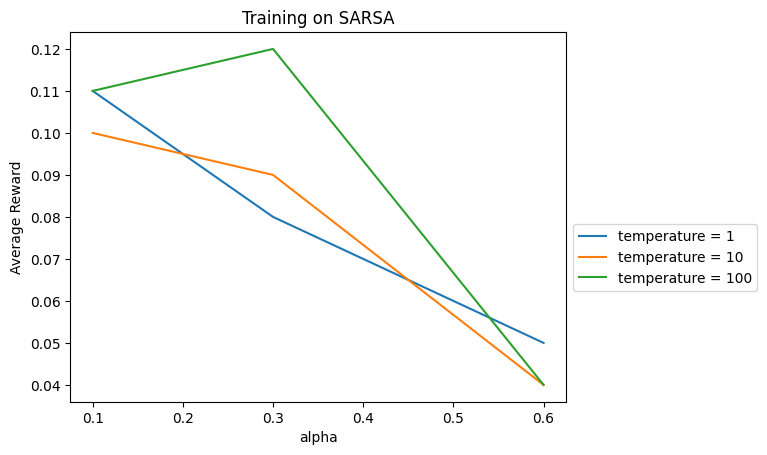

In [9]:
for temp in tqdm(TEMPERATURE):
    rewards_train = []
    for alpha in ALPHAS:
        average_reward_train = 0
        for seed in SEEDS:
            random.seed(seed)
            
            env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True)
            env.reset()
            sarsa = SARSA(env, alpha, temp, GAMMA, EPISODES, False)
            sarsa.simulate_episodes()
            final_policy = sarsa.learned_policy
            train_reward = sarsa.train_reward()
            average_reward_train += train_reward
            
        average_reward_train = average_reward_train/10
        rewards_train.append(average_reward_train)
        
    plt.plot(ALPHAS, rewards_train, label = f"temperature = {temp}")

plt.legend(bbox_to_anchor = (1, 0.5), loc = "best")
plt.title("Training on SARSA")
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.show()

### Effect of parameters on final testing performance for SARSA

In [11]:
for temp in tqdm(TEMPERATURE):
    rewards_test = []
    for alpha in ALPHAS:
        average_reward_test = 0
        for seed in SEEDS:
            random.seed(seed)
            
            env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True)
            env.reset()
            sarsa = SARSA(env, alpha, temp, GAMMA, EPISODES, False)
            sarsa.simulate_episodes()
            final_policy = sarsa.learned_policy
            test_reward = sarsa.test_reward()
            average_reward_test += test_reward
            
        average_reward_test = average_reward_test/10
        rewards_test.append(average_reward_test)
        
    # for (a, r) in zip(ALPHAS, rewards_test):
    #     print(f"temperature {temp}: {(a,r)}")
    plt.plot(ALPHAS, rewards_test, label = f"temperature = {temp}")

plt.legend(bbox_to_anchor = (1, 0.5), loc = "best")
plt.title("Testing on SARSA")
plt.xlabel("alpha")
plt.ylabel("Average Reward")
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\Ling0\AppData\Local\Temp\ipykernel_11608\2582660103.py:6: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)
100%|██████████| 5500/5500 [00:01<00:00, 4485.91it/s]

  0%|          | 0/3 [00:01<?, ?it/s]


KeyboardInterrupt: 

### Best parameter for SARSA

### Conclusion for SARSA

### Effect of parameters on final training performance for EXPECTED SARSA

### Effect of parameters on final testing performance for EXPECTED SARSA

### Best parameter for EXPECTED SARSA

### Conclusion for EXPECTED SARSA